# Relative Vorticity

This notebook shows a simple example of calculation the vertical component of relative vorticity,

$$\zeta = \partial_x v - \partial_y u.$$

For demonstration purposes we will compute the vorticity near the surface, but the method can be applied to any depth.

We will demonstrate three methods for computing relative voritcity:

1. A naïve method of simply converting degrees of longitude/latitude into metres and differentiating.
    This method works if you simply wanna have a look at how the vorticity field looks like.
2. A much more careful way of replicating *exactly* what the model does for computing the vertical component of relative vorticity.
3. A simpler but accurate method leveraging the functionality of the `xgcm`.

**Caveat: Both methods 2 and 3 automatically extend land masks into the domain, so needs extreme care if you care about coastlines!** see https://github.com/xgcm/xgcm/issues/324

(To make a long story short: best method is probably method 3.)

**Requirements:** The `conda/analysis3-24.04` (or later) module on the VDI/gadi (or your own up-to-date cookbook installation).

**Firstly,** load in the requisite libraries:

In [1]:
import intake

import xarray as xr
import cf_xarray as cfxr
import numpy as np
from dask.distributed import Client

import matplotlib.pyplot as plt
import cmocean as cm
import matplotlib

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=False)

Load a `dask` client.

In [2]:
client = Client(threads_per_worker=1)
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46823 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/46823/status,
Dashboard: /proxy/46823/status,Workers: 48
Total threads: 48,Total memory: 188.55 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35249,Workers: 48
Dashboard: /proxy/46823/status,Total threads: 48
Started: Just now,Total memory: 188.55 GiB
Comm: tcp://127.0.0.1:43801,Total threads: 1
Dashboard: /proxy/34479/status,Memory: 3.93 GiB
Nanny: tcp://127.0.0.1:39163,


Use the ACCESS-NRI default catalog.

In [3]:
catalog = intake.cat.access_nri

Various parameters that will be used for computing quantities.

In [4]:
# values used by MOM5

Ω = 7.292e-5     # Earth's rotation rate; in radians/s
Rearth = 6371e3  # Earth's radius; in m

Load `lon` and `lat` used in the experiment. These datasets can be used for plotting.

In [5]:
experiment = '025deg_jra55_iaf_omip2_cycle2'

cat_subset = catalog[experiment]

var_search = cat_subset.search(variable='geolon_c')
var_search = var_search.search(path=var_search.df['path'][0])
darray = var_search.to_dask()
lon = darray['geolon_c']

var_search = cat_subset.search(variable='geolat_c')
var_search = var_search.search(path=var_search.df['path'][0])
darray = var_search.to_dask()
lat = darray['geolat_c']

Calculate the Coriolis parameter $f = 2\Omega \sin(\texttt{lat})$.

In [6]:
f = 2 * Ω * np.sin(np.deg2rad(lat)) # convert lat in radians
f = f.rename('Coriolis')
f.attrs['long_name'] = 'Coriolis parameter'
f.attrs['units'] = 's-1'
f.attrs['coordinates'] = 'geolon_c geolat_c'

Load the $u$ and $v$ velocity snapshots. Then we pick a depth value below the Ekman layer, namely the closest to $z=-30\,m$.

The code `.isel(time=-1)` selects the final snapshot of `u` or `v`. Remove `.isel(time=-1)` to load **all** available snapshots of the flow fields.

In [7]:
depth = 30 #m; avoid the surface Ekman layer by taking the "surface values" at some depth close to the surface

var_search = cat_subset.search(variable='u')
darray = var_search.to_dask()
u = darray['u']
u = u.isel(time=-1).cf.sel(vertical=depth, method='nearest')

var_search = cat_subset.search(variable='v')
darray = var_search.to_dask()
v = darray['v']
v = v.isel(time=-1).cf.sel(vertical=depth, method='nearest')

## Method 1 (naïve computation)

To compute relative vorticity $\zeta = \partial_x v - \partial_y u$ we simply differentiate the velocity components with respect of `lon` (here `xu_ocean` in degrees) and `lat` (here `yu_ocean` in degrees). We then convert the derivatives from units of degrees$^{-1}$ to m$^{-1}$. To do so, we use the value of the radius of the Earth `Rearth` and also take into account that as we go towards the poles the `lon`-grid spacing is scaled by $\cos($ `lat` $)$.

(Note the unicode characters like `ζ` can be used in `python`.)

In [8]:
ζ_naive = v.differentiate('xu_ocean') / np.deg2rad(Rearth * np.cos(np.deg2rad(lat))) - u.differentiate('yu_ocean') / (np.pi / 180 * Rearth)
ζ_naive = ζ_naive.rename('Relative Vorticity')
ζ_naive.attrs['long_name'] = 'Relative Vorticity, ∂v/∂x-∂u/∂y'
ζ_naive.attrs['units'] = 's-1'

In [9]:
ζ_naive

<xarray.DataArray 'Relative Vorticity' (yu_ocean: 1080, xu_ocean: 1440)> Size: 6MB
dask.array<sub, shape=(1080, 1440), dtype=float32, chunksize=(108, 120), chunktype=numpy.ndarray>
Coordinates:
    time      datetime64[ns] 8B 2018-12-14T12:00:00
    st_ocean  float64 8B 30.36
  * xu_ocean  (xu_ocean) float64 12kB -279.8 -279.5 -279.2 ... 79.5 79.75 80.0
  * yu_ocean  (yu_ocean) float64 9kB -81.02 -80.92 -80.81 ... 89.79 89.89 90.0
    geolat_c  (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(216, 240), meta=np.ndarray>
    geolon_c  (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(216, 240), meta=np.ndarray>
Attributes:
    long_name:  Relative Vorticity, ∂v/∂x-∂u/∂y
    units:      s-1

We now plot $\zeta$ in the North Atlantic.

In [10]:
maxvalue = 6e-6
levels = np.linspace(-maxvalue, maxvalue, 24)

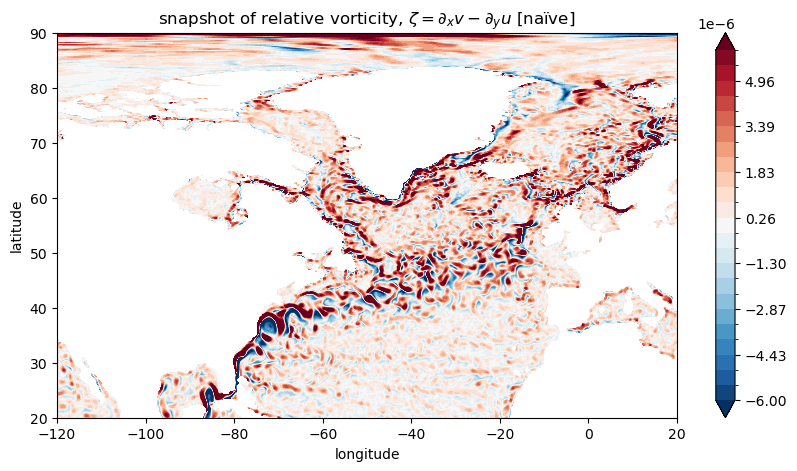

In [11]:
fig = plt.figure(figsize=(10, 5))
ζ_naive.plot.contourf(levels=levels, x='geolon_c', y='geolat_c', cmap="RdBu_r", vmin=-maxvalue, vmax=maxvalue, extend='both', add_labels=False)
plt.title("snapshot of relative vorticity, $\zeta = \partial_x v - \partial_y u$ [naïve]");
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.xlim(-120, 20)
plt.ylim(20, 90);

This method is sort-of-OK below 65N where the complications of the tripolar grid do not enter. But even south of 65N this method gives a rough estimate. It's OK for visualising but it should **not** be used in computing, e.g., vorticity budgets.

## Method 2: replicating how MOM5 computes `vorticity_z`

Looking at [MOM5 code](https://github.com/mom-ocean/MOM5/blob/64990e1de853a175335848b67b580363053a79b4/src/mom5/ocean_diag/ocean_velocity_diag.F90#L1172-L1183) and by doing some translation from Fortran code to "english" we can see that the models computes `vorticity_z` via:

$$ \zeta(i, j, k) = \frac1{2}\Big[ \underbrace{ \frac{v(i,j,k) - v(i-1,j,k)}{\Delta x_{N}(i,j,k)} }_{\approx \partial_x v(i,j,k)} +  \underbrace{\frac{v(i,j-1,k) - v(i-1,j-1,k)}{\Delta x_{N}(i,j-1,k)}}_{\approx \partial_x v(i,j-1,k)} \Big] \\
\qquad \qquad \qquad -  \frac1{2}\Big[ \underbrace{ \frac{u(i,j,k) - u(i,j-1,k)}{\Delta y_{E}(i,j,k)} }_{\approx \partial_y u(i,j,k)} +  \underbrace{\frac{u(i-1,j,k) - u(i-1,j-1,k)}{\Delta y_{E}(i-1,j,k)}}_{\approx \partial_y u(i,j-1,k)} \Big].$$

Above, $(i, j, k)$ refers to the grid-point indices for directions $x, y, z$ respectively. 

The distances $\Delta x_N$ and $\Delta y_E$ correspond to the North and East faces of the corresponding $T$-cell; see the diagram below. (T-points are those in the cells's centres where tracers are evaluated and U-points are in the cells's corners where velocities are evaluated.)

![](images/Bgrid.png)

In [12]:
ds_grid = xr.open_mfdataset('/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_iaf_gmredi6/output000/ocean/ocean_grid.nc', combine='by_coords')
ds = xr.merge([u, v, ds_grid])

After a lot of fiddling with indiced you can confirm that the right way to compute $\delta x_N$ and $\delta y_E$ from above is:

In [13]:
inverse_dxtn = 0.5*(1/ds.dxu + np.roll(1/ds.dxu, 1, axis=1))
inverse_dyte = 0.5*(1/ds.dyu + np.roll(1/ds.dyu, 1, axis=0))

... and with that we can now compute `ζ_mom5` which is the vorticity as exactly the way is computed by the model:

In [14]:
vx_ijk = (ds.v - np.roll(ds.v, 1, axis=1)) * inverse_dxtn
uy_ijk = (ds.u - np.roll(ds.u, 1, axis=0)) * inverse_dyte

vx = 0.5 * (vx_ijk + np.roll(vx_ijk, 1, axis=0))
uy = 0.5 * (uy_ijk + np.roll(uy_ijk, 1, axis=1))

ζ_mom5 = vx - uy

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 11.91 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 11.91 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


The way we computed `ζ_mom5` above using `numpy.roll` is not really ideal. One would like to do the above using `xarray`'s functionality... But, as we will argue below, you shouldn't be using this way anyway because it's cumbersome and it requires you to know the specifics of the staggered grid used in the model (Arakawa B-grid for MOM5). A way to avoid getting into the nitty-gritty of staggered grids is to use `xgcm` packaged (described in **Method 3**).

With this and that let's plot `ζ_mom5`.

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 35.72 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


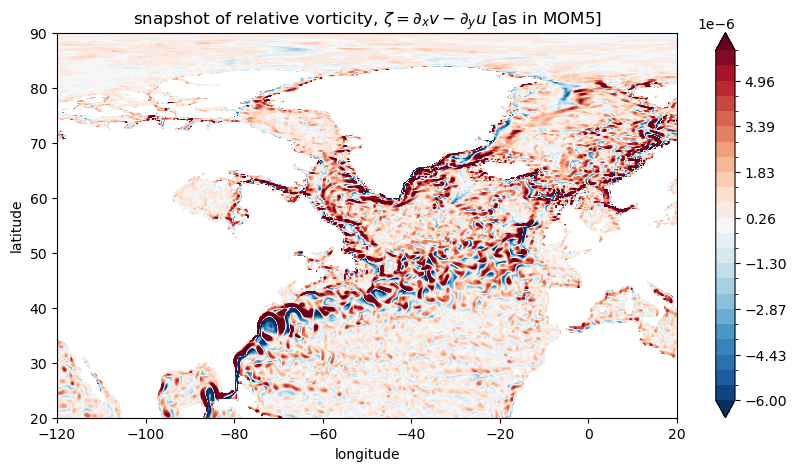

In [15]:
fig = plt.figure(figsize=(10, 5))

ζ_mom5.plot.contourf(levels=levels,
                     x='geolon_c', y='geolat_c',
                     cmap="RdBu_r", vmin=-maxvalue, vmax=maxvalue, extend='both', add_labels=False)

plt.title("snapshot of relative vorticity, $\zeta = \partial_x v - \partial_y u$ [as in MOM5]")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.xlim(-120, 20)
plt.ylim(20, 90);

Note that the Arctic region now looks more "reasonable".

## Method 3: Using `xgcm` to replicate MOM5's calculation for `vorticity_z`

[`xgcm`](https://xgcm.readthedocs.io/en/stable/) is a package that deals with staggered grids that are typically used in ocean models. An excerpt from `xgcm`'s docs mentions:

> "(in model output datasets), different variables are located at different positions with respect to a volume or area element (e.g. cell center, cell face, etc.) xgcm solves the problem of how to interpolate and difference these variables from one position to another."

In [16]:
import xgcm
print("xgcm version ", xgcm.__version__)

xgcm version  0.8.1


The way `xgcm` works is that we first create a `grid` object that has all the information regarding our staggered grid. For our case, `grid` needs to know the location of the `xt_ocean`, `xu_ocean` points (and same for $y$) and their relative orientation to one another, i.e., that `xu_ocean` is shifted to the right of `xt_ocean` by $\frac1{2}$ grid-cell.

In [17]:
folder = '/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_iaf_gmredi6/output000/ocean/'
grid = xr.open_mfdataset(folder + 'ocean_grid.nc', combine='by_coords')

ds = xr.merge([u, v, grid])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid = xgcm.Grid(ds, periodic=['X'])

Then, `xgcm` give you a way to interpolate between grids (with the `.interp` function) and a way to compute differences (`.diff` function). For example, the exrpession $v(i,j,k) - v(i-1,j,k)$ is obtained via `grid.diff(ds.v, 'X')`.

Using `xgcm`'s functionality we can replicate the MOM5 vertical vorticity computation as:

In [18]:
ζ_xgcm = (+ grid.interp( grid.diff(ds.v, 'X') / grid.interp(ds.dxu, 'X'), 'Y', boundary='extend')
          - grid.interp( grid.diff(ds.u, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'X') )

ζ_xgcm = ζ_xgcm.rename('Relative Vorticity')
ζ_xgcm.attrs['long_name'] = 'Relative Vorticity, ∂v/∂x-∂u/∂y'
ζ_xgcm.attrs['units'] = 's-1'

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return

(**Note**: A simpler expression for `ζ_xgcm` could be:
```python
ζ_xgcm = (+ grid.interp(grid.diff(ds.v, 'X'), 'Y', boundary='extend') / ds.dxt
          - grid.interp(grid.diff(ds.u, 'Y', boundary='extend'), 'X') / ds.dyt)
```
However, the above does not replicate precisely the way MOM5 computes `vorticity_z`.)

Now, let's plot `ζ_xgcm`...

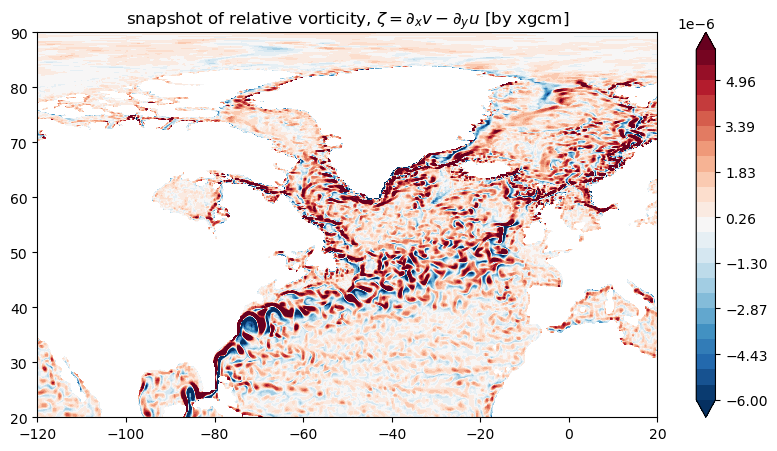

In [19]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)

p = ax.contourf(lon, lat, ζ_xgcm.values,
                levels=levels, cmap="RdBu_r", vmin=-maxvalue, vmax=maxvalue, extend='both')

ax.set_title("snapshot of relative vorticity, $\zeta = \partial_x v - \partial_y u$ [by xgcm]")
plt.colorbar(p, extend='both')
plt.xlim(-120, 20)
plt.ylim(20, 90);

Looks OK and it was definitely easier than method 2.

## Comparison of the three methods

Now let's be thorough and compare the vorticities computed via the three methods.

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 35.72 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


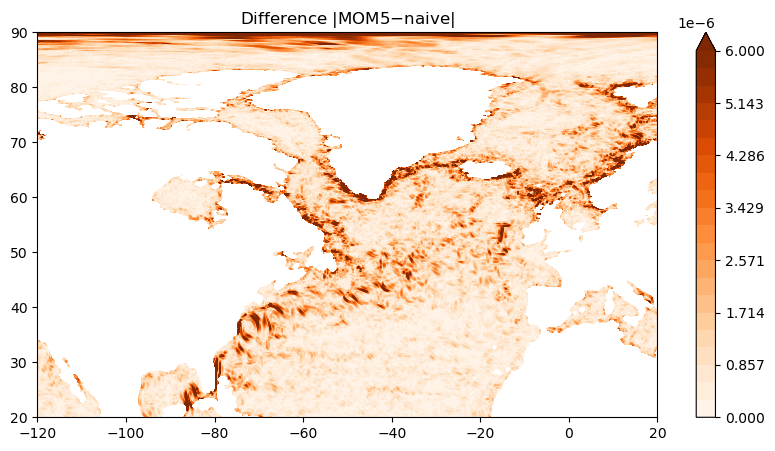

In [20]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)

p = ax.contourf(lon, lat, np.abs(ζ_mom5.values - ζ_naive.values),
                levels=np.linspace(0, maxvalue, 22),
                cmap="Oranges", vmin=0, vmax=maxvalue, extend='max')

ax.set_title("Difference $|$MOM5$-$naive$|$")
plt.colorbar(p, extend='both')
plt.xlim(-120, 20)
plt.ylim(20, 90);

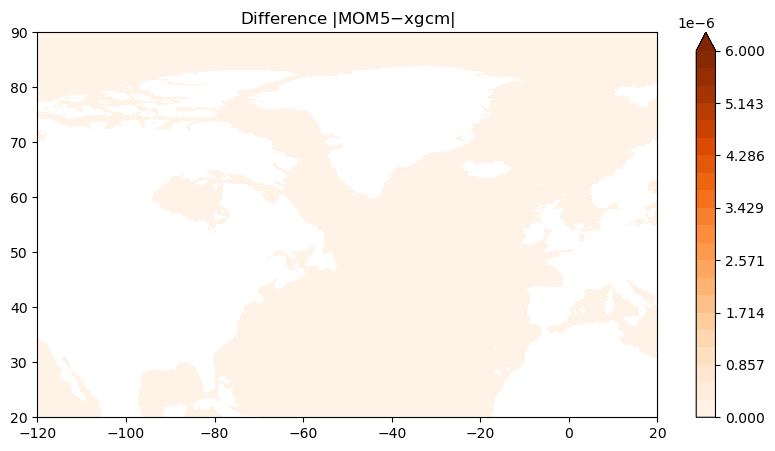

In [21]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)

p = ax.contourf(lon, lat, np.abs(ζ_mom5.values - ζ_xgcm.values),
                levels=np.linspace(0, maxvalue, 22),
                cmap="Oranges", vmin=0, vmax=maxvalue, extend='max')

ax.set_title("Difference $|$MOM5$-$xgcm$|$")
plt.colorbar(p, extend='max')
plt.xlim(-120, 20)
plt.ylim(20, 90);

Indeed the `xgcm` method gives **the same** as the `MOM5` code.

We have confirmed that indeed `ζ_mom5` corresponds exactly to the `vorticity_z` diagnostic that the model outputs. To test this, the model was run for 1 day, save `u`, `v` and `vorticity_z` and then confirm that the `ζ_mom5` computation from method 2 is equal to `vorticity_z` (up to machine precision). For brevity this comparison is not included here.

## Further Potential Improvements on Method 3

`xgcm` has a functionality to perform derivatives and interpolations using the grid metrics. Implementing that would simplify the vorticity calculations **even more**, e.g.,

```python
ζ_xgcm = grid.derivative(ds.v, 'X') - grid.derivative(ds.u, 'Y')

```
Something like that would be terrific; the user will only have to type up the algebraic expression of what they want to compute without any reference to `dxt` or `dxu` distances...

## The Rossby number

To conclude, let's visualize the Rossby number

$$\mathrm{Ro} = \frac{\zeta }{f},$$

where $f=2\Omega\sin(\theta)$ is the Coriolis parameter.

In [22]:
f = grid.interp(grid.interp(f, 'X'), 'Y', boundary='extend')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


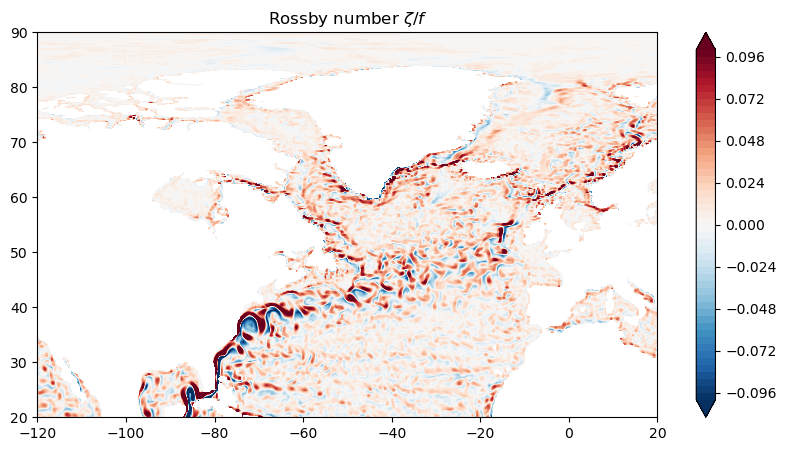

In [23]:
Ro = ζ_xgcm / f
Ro = Ro.rename('Rossby number ζ/f')

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)

p = ax.contourf(lon, lat, Ro,
                levels=np.linspace(-0.1, 0.1, 51),
                cmap="RdBu_r", vmin=-0.1, vmax=0.1, extend='both')

ax.set_title("Rossby number $\zeta/f$")
plt.colorbar(p, extend='both')
plt.xlim(-120, 20)
plt.ylim(20, 90);